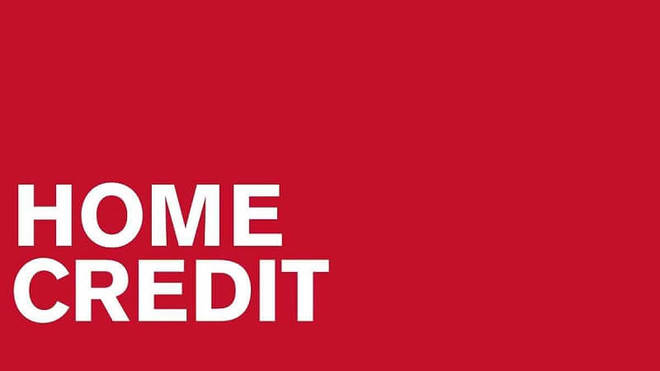

Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders.

Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're challenging Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful.

References: https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction#Data


# DRIVE CONNECTION

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# IMPORT LIBRARIES

In [ ]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 26 kB/s 


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix, plot_confusion_matrix, roc_curve
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA

# DATASET

In [ ]:
description = pd.read_csv('/content/drive/MyDrive/HOME CREDIT DEFAULT RISK/HomeCredit_columns_description.csv', encoding="ISO-8859-1")

In [ ]:
description

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
...,...,...,...,...,...
214,217,installments_payments.csv,NUM_INSTALMENT_NUMBER,On which installment we observe payment,NaN
215,218,installments_payments.csv,DAYS_INSTALMENT,When the installment of previous credit was su...,time only relative to the application
216,219,installments_payments.csv,DAYS_ENTRY_PAYMENT,When was the installments of previous credit p...,time only relative to the application
217,220,installments_payments.csv,AMT_INSTALMENT,What was the prescribed installment amount of ...,NaN


* application_{train|test}.csv

1. This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
2. Static data for all applications. One row represents one loan in our data sample.

* bureau.csv

1. All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
2. For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.
bureau_balance.csv

* Monthly balances of previous credits in Credit Bureau.
1. This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

* POS_CASH_balance.csv
1. Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
2. This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

* credit_card_balance.csv
1. Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
2. This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

* previous_application.csv

1. All previous applications for Home Credit loans of clients who have loans in our sample.
2. There is one row for each previous application related to loans in our data sample.

* installments_payments.csv
1. Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
2. There is a) one row for every payment that was made plus b) one row each for missed payment.
3. One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

In [ ]:
bureau = pd.read_csv('/content/drive/MyDrive/HOME CREDIT DEFAULT RISK/bureau.csv')

In [ ]:
bureau.head(3)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN


Văn phòng tín dụng (CREDIT BUREAU) là cơ quan tập hợp dữ liệu cho ngân hàng, các định chế tiết kiệm và các tổ chức tín dụng khác về lịch sử của khách hàng - lịch sử tín dụng của họ - đáp ứng các nghĩa vụ, dựa trên thông tin do các nhà cấp tín dụng yêu cầu. Thông tin này được phân phát có thu phí cho các nhà cấp tín dụng khác, họ sẽ sử dụng nó để quyết định có chấp thuận hay từ chối đơn xin cấp tín dụng, và mức tín dụng cấp cho người vay cụ thể là bao nhiêu. Ví dụ, công ty phát hành thẻ tín dụng cung ứng các thẻ tín dụng được chấp thuận trước, thường xác định ai sẽ được thể này, bằng cách xem xét các báo cáo của văn phòng tín dụng, người chấp nhận thẻ theo những điều khoản đưa ra sẽ mở một tài khoản.


A credit bureau, also known in the U.S. as a credit reporting agency, is an organization that collects and researches individual credit information and sells it to creditors for a fee, so they can make decisions about extending credit or granting loans.

https://www.investopedia.com/terms/c/creditbureau.asp

https://rpubs.com/Saurabhmallik/428847

* **AMT_ANNUITY**: An annuity is a fixed amount of money that you will get each year for the rest of your life. An annuity is a contract between you and an insurance company that requires the insurer to make payments to you, either immediately or in the future.

* **DAYS_CREDIT_UPDATE**: Your credit scores typically update at least once a month. However, this may vary depending on your unique financial situation. Credit scores are calculated based on the information included in your credit reports. So, for your credit scores to update, the information in your credit reports must first change. Days credit update negative means it is due by that days

* **CREDIT_TYPE**: Consumer credit is personal debt taken on to purchase goods and services. A credit card is one form of consumer credit. Although any type of personal loan could be labeled consumer credit, the term is more often used to describe unsecured debt that is taken on to buy everyday goods and services.

* SK_ID_CURR: ID of loan, which may have 0 or more related previous credits in credit bureau

* SK_BUREAU_ID: Unique ID of existing Credit Bureau credit related to the loan

* CREDIT_ACTIVE: Status of the Credit Bureau (CB) reported credits

* CREDIT_CURRENCY: Recoded currency of the Credit Bureau credit

* DAYS_CREDIT: How many days before current application did client apply for Credit Bureau credit (*số lượng ngày từ lúc client được đưa vào Bureau Credit tới lúc đăng ký hiện tại*). 

* CREDIT_DAY_OVERDUE: Number of days past due on CB credit at the time of application of loan

* DAYS_CREDIT_ENDDATE: Remaining duration of CB credit (in days) at the time of application in Home Credit

* DAYS_ENDDATE_FACT: Days since CB credit ended at the time of application in Home Credit (only for closed credit)

* AMT_CREDIT_MAX_OVERDUE: Maximal amount overdue on the Credit Bureau credit so far

* CNT_CREDIT_PROLONG: How many times was the Credit Bureau credit prolonged

* AMT_CREDIT_SUM: Current credit amount for the Credit Bureau credit

* AMT_CREDIT_SUM_DEBT: Current debt on Credit Bureau credit

* AMT_CREDIT_SUM_LIMIT: Current credit limit of credit card reported in Credit Bureau

* AMT_CREDIT_SUM_OVERDUE: Current amount overdue on Credit Bureau credit

Đơn giản là Bureau credit cũng là cơ quan thu thập thông tin lịch sử khách hàng, lịch sử tín dụng. Thông tin này sẽ được bán lại cho các cơ quan tổ chức cần

All client's previous credits provided by other financial institutions that were reported to Credit Bureau.

In [ ]:
bureau_balance = pd.read_csv('/content/drive/MyDrive/HOME CREDIT DEFAULT RISK/bureau_balance.csv')

In [ ]:
bureau_balance.head(3)

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C


* SK_BUREAU_ID: Unique ID of existing Credit Bureau credit related to the loan

* MONTHS_BALANCE: MONTHS_BALANCE:- Month of balance relative to the application date (-1 means the freshest balance date). A balance date is the last day of an accounting year. For most businesses the accounting year begins on 1 April and ends the following 31 March

* STATUS: Status of Credit Bureau loan during the month (C means closed, X means status unknown, 0 means no DPD, 1 means maximal did during month between 1-30, 2 means DPD 31-60 etc.)

In [ ]:
POS_CASH_Balance = pd.read_csv('/content/drive/MyDrive/HOME CREDIT DEFAULT RISK/POS_CASH_balance.csv')

In [ ]:
POS_CASH_Balance.head(3)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0


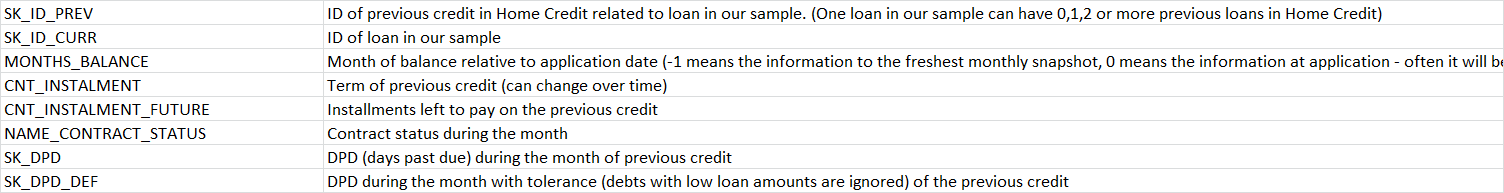

* CNT_INSTALMENT: Installment credit is a loan that offers a borrower a fixed, or finite, amount of money over a specified period of time. This way, the borrower knows upfront the number of monthly payments, or “installments,” they will need to make and how much each monthly payment will be.

* DPD: Days Past Due shows the number of days by which you have missed an EMI or credit card payment


In [ ]:
credit_card_balance = pd.read_csv('/content/drive/MyDrive/HOME CREDIT DEFAULT RISK/credit_card_balance.csv')

In [ ]:
credit_card_balance.head(3)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0


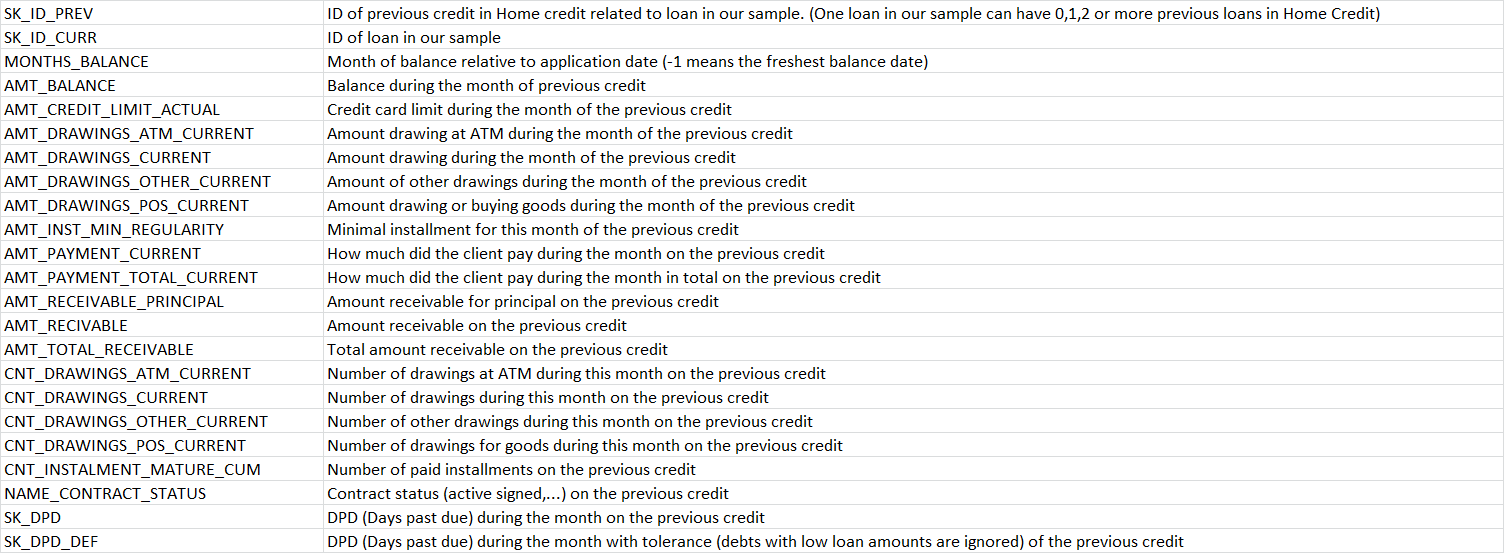

* A credit card balance is the total amount of money that you owe to your credit card company.



In [ ]:
instalmment_payments = pd.read_csv('/content/drive/MyDrive/HOME CREDIT DEFAULT RISK/installments_payments.csv')

In [ ]:
instalmment_payments.head(3)

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000


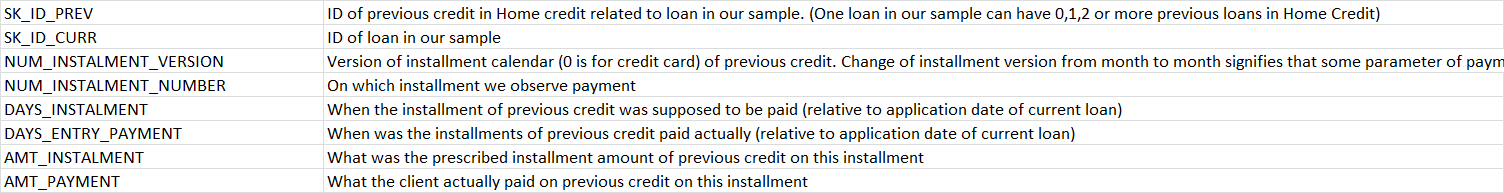

In [ ]:
previous_application = pd.read_csv('/content/drive/MyDrive/HOME CREDIT DEFAULT RISK/previous_application.csv')

In [ ]:
previous_application.head(3)

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0


# APPLICATION TRAIN - APPLICATION TEST

In [ ]:
application_train = pd.read_csv('/content/drive/MyDrive/HOME CREDIT DEFAULT RISK/application_train.csv')

In [ ]:
application_train.head(3)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
application_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [ ]:
application_test = pd.read_csv('/content/drive/MyDrive/HOME CREDIT DEFAULT RISK/application_test.csv')

In [ ]:
application_test.head(3)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0


# DISTRIBUTION

In [ ]:
# Distribution of the target variable
application_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

Imbalanced class problem: There are far more loans that were repaied on time than loans that were not repaid

In [ ]:
def missing_values_table(df):
  mis_val = df.isnull().sum()

  # Percentage of missing values
  mis_val_percent = df.isnull().sum() / len(df)

  # Make a table with the results
  mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
  
  # Rename the columns
  mis_val_table_ren_columns = mis_val_table.rename(
  columns = {0 : 'Missing Values', 1 : '% of Total Values'})
  
  # Sort the table by percentage of missing descending
  mis_val_table_ren_columns = mis_val_table_ren_columns[
      mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
  '% of Total Values', ascending=False).round(1)
  
  # Print some summary information
  print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
      "There are " + str(mis_val_table_ren_columns.shape[0]) +
        " columns that have missing values.")
  
   # Return the dataframe with missing information
  return mis_val_table_ren_columns

In [ ]:
# Missing values statistics
missing_values = missing_values_table(application_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,0.7
COMMONAREA_AVG,214865,0.7
COMMONAREA_MODE,214865,0.7
NONLIVINGAPARTMENTS_MEDI,213514,0.7
NONLIVINGAPARTMENTS_MODE,213514,0.7
NONLIVINGAPARTMENTS_AVG,213514,0.7
FONDKAPREMONT_MODE,210295,0.7
LIVINGAPARTMENTS_MODE,210199,0.7
LIVINGAPARTMENTS_MEDI,210199,0.7
LIVINGAPARTMENTS_AVG,210199,0.7


In [ ]:
# Columns Types
application_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [ ]:
application_train.select_dtypes('object').apply(pd.Series.nunique, axis=0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

# DATA PREPROCESSING

In [ ]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in application_train:
    if application_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(application_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(application_train[col])
            # Transform both training and testing data
            application_train[col] = le.transform(application_train[col])
            application_test[col] = le.transform(application_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [ ]:
# One hot encoding of categorical value
application_train = pd.get_dummies(application_train)
application_test = pd.get_dummies(application_test)

In [ ]:
application_train.shape, application_test.shape

((307511, 243), (48744, 239))

In [ ]:
# Aligning Training and Testing data
# One-hot encoding has created more columns in the training data because there are
# some categories not represented in the testing data.

# We need to extract the target column from the training data
# With align, we only need columns appearing in both dataset

train_labels = application_train['TARGET']
application_train, application_test = application_train.align(application_test, join="inner", axis=1)

# Add the target back
application_train['TARGET'] = train_labels

print('Training features shape: ', application_train.shape)
print('Testing features shape: ', application_test.shape)

Training features shape:  (307511, 240)
Testing features shape:  (48744, 239)


# ANOMALIES

In [ ]:
# Day births negative because they are calculated from the birth to the current loan application
(application_train['DAYS_BIRTH']/-365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

Age looks reasonable because there are no outliers for the age on either the high or low end

In [ ]:
application_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

This does not look reasonable because the maximum value is about 100 years

Text(0.5, 0, 'Days Employment')

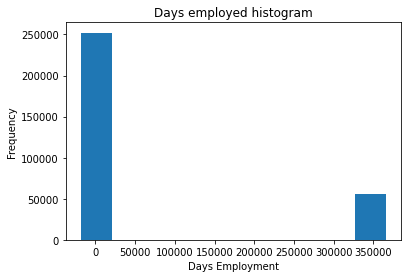

In [ ]:
application_train['DAYS_EMPLOYED'].plot.hist(title='Days employed histogram')
plt.xlabel('Days Employment')

We would like to know if the anomalies have greater tendency to default than those who are not in the group of anomaly

In [ ]:
anomalies = application_train[application_train['DAYS_EMPLOYED']>=50000]
not_anomalies = application_train[application_train['DAYS_EMPLOYED']<50000]
print('The percentage of anomalies defaulting: ', anomalies['TARGET'].mean()*100)
print('The percentage of not anomalies defaulting: ', not_anomalies['TARGET'].mean()*100)

The percentage of anomalies defaulting:  5.399646043269405
The percentage of not anomalies defaulting:  8.65997453765215


From the statistics, it could be seen that the people who are in the anomalies group are less likely to default.

In order to remove the ouliers. We would set the anomalies to missing value and then perform imputation before machine learning. As a solution, we will fill in the anomalous values with np.nan and create a new boolean column indicating whether ot not the value was anomalous

Text(0.5, 0, 'Days Employment')

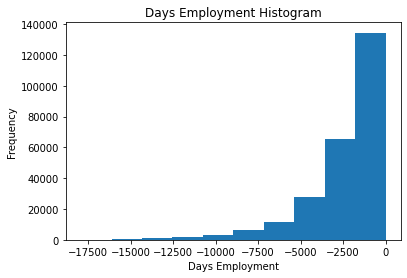

In [ ]:
# Create an anomalous flag column
application_train['DAYS_EMPLOYED_ANOM'] = application_train['DAYS_EMPLOYED']>=50000
application_train.loc[application_train['DAYS_EMPLOYED']>=50000,'DAYS_EMPLOYED'] = np.nan
application_train['DAYS_EMPLOYED'].plot.hist(title='Days Employment Histogram')
plt.xlabel('Days Employment')

The % of anomalies in the test dataset is:  9274


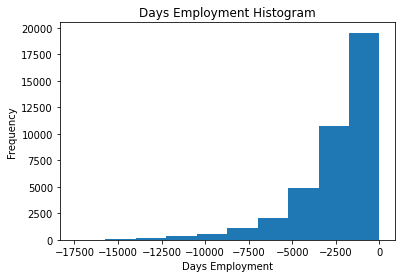

In [ ]:
# Outliers in the application_test
application_test['DAYS_EMPLOYED_ANOM'] = application_test['DAYS_EMPLOYED']>=50000
application_test.loc[application_test['DAYS_EMPLOYED']>=50000,'DAYS_EMPLOYED'] = np.nan
application_test['DAYS_EMPLOYED'].plot.hist(title='Days Employment Histogram')
plt.xlabel('Days Employment')

print('The % of anomalies in the test dataset is: ', application_test['DAYS_EMPLOYED_ANOM'].sum())


# CORRELATION

In [ ]:
correlation = application_train.corr()['TARGET'].sort_values()
print('Most Positive Correlation:', correlation.tail(15))
print('Most Negative Correlation: ', correlation.head(15))

Most Positive Correlation: OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64
Most Negative 

In [ ]:
# Change the effect of age on repayment
application_train['DAYS_BIRTH'] = abs(application_train['DAYS_BIRTH'])
application_test['DAYS_BIRTH'] = abs(application_test['DAYS_BIRTH'])

As the client gets older, they are more likely to repay their loans more often

#VISUALIZATIONS

## Age group

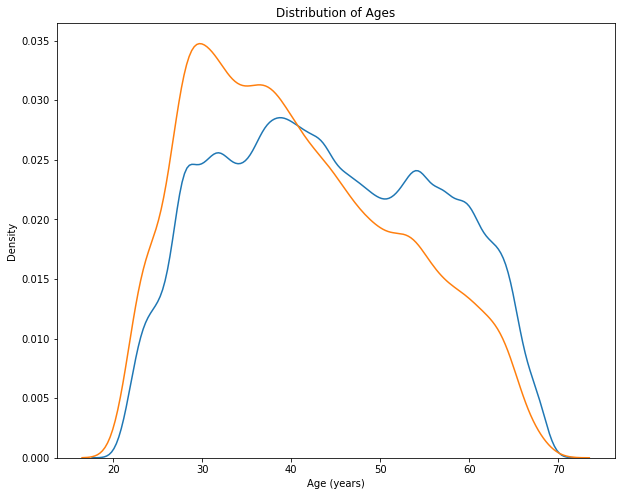

In [ ]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(application_train.loc[application_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(application_train.loc[application_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)') 
plt.ylabel('Density')
plt.title('Distribution of Ages');

The target == 1 curve skews towards the younger end of the range. In order to make this more apparent, we would cut this into bins

In [ ]:
age_data = application_train[['TARGET','DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH']/365

age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins=np.linspace(20,70,num=11))
age_data.head(10)

<ipython-input-48-ab9f8fb7fa22>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH']/365
<ipython-input-48-ab9f8fb7fa22>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins=np.linspace(20,70,num=11))


,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [ ]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


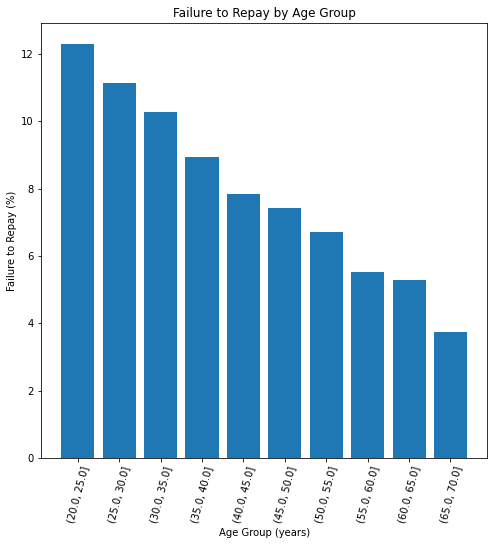

In [ ]:
# Check the ability to default for each age group
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

Younger applicants are more likely to not repay the loan. It would be smart to take precautionary measures to help the young applicants repay on time

## DOMAIN KNOWLEDGE FEATURE

* CREDIT_INCOME_PERCENT: percentage of credit amount relative to a client's income

* ANNUITY_INCOME_PERCENT: percentage of loan annuity relative to a client's income

* CREDIT_TERM: the length of the payment in months (annuity is monthly amount due)

* DAYS_EMPLOYED_PERCENT: percentage of days employed relative to client's age

In [ ]:
app_train_domain = application_train.copy()
app_test_domain = application_test.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

In [ ]:
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

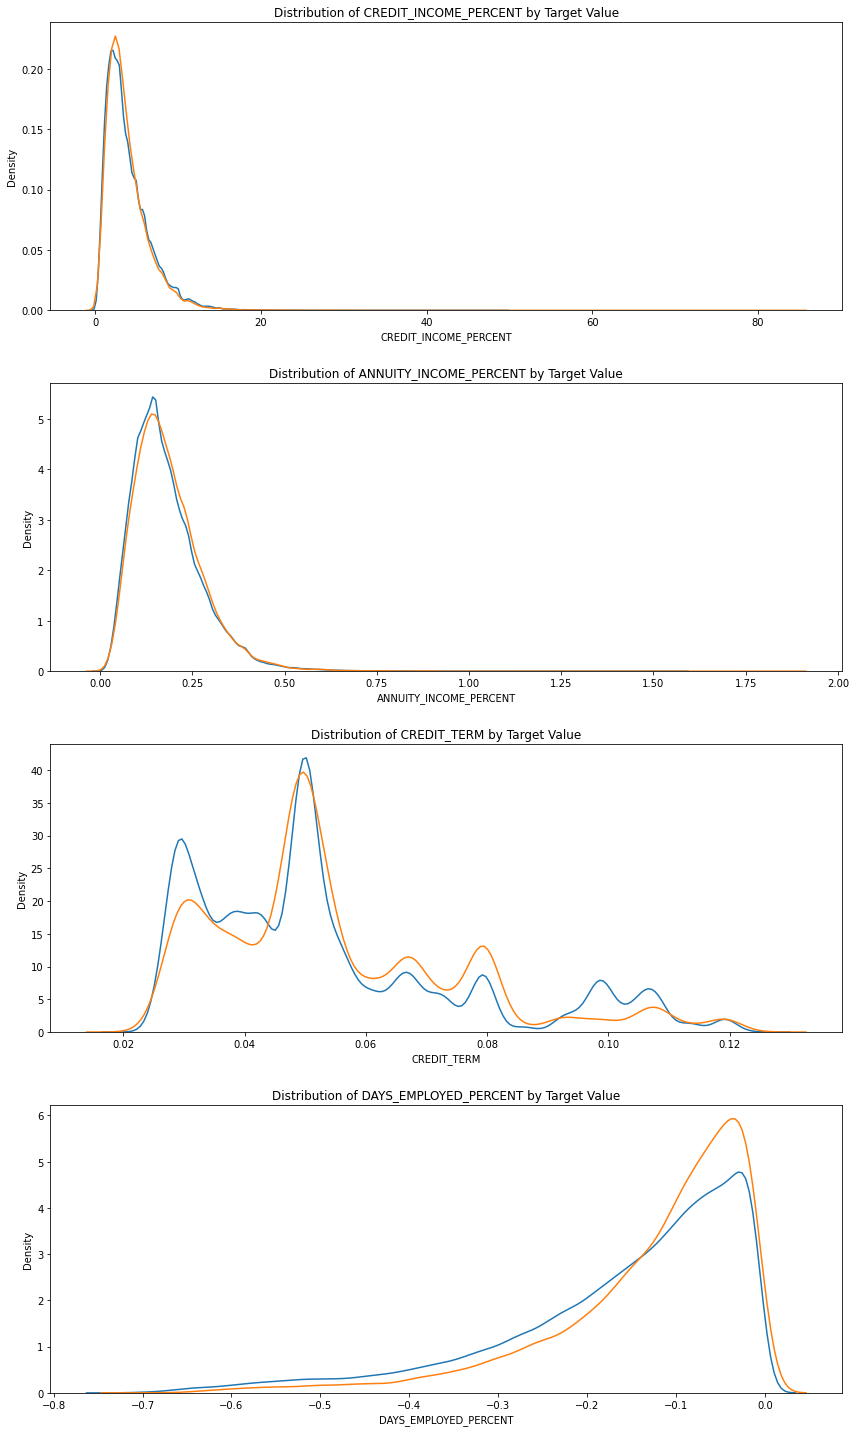

In [ ]:
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

# APPLYING MODEL

## SPLIT DATASET

In [ ]:
train = application_train.drop('TARGET', axis=1)
label = application_train['TARGET']
test = application_test.copy()

In [ ]:
imputer = SimpleImputer(strategy='median')
scaler = MinMaxScaler(feature_range=(0,1))
imputer.fit(train)
scaler.fit(train)

MinMaxScaler()

In [ ]:
train = imputer.transform(train)
test = imputer.transform(test)

train = scaler.transform(train)
test = scaler.transform(test)

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [ ]:
print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (307511, 240)
Testing data shape:  (48744, 240)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train, label, test_size=0.2, random_state=42)

## BASELINE

In [ ]:
# log_reg = LogisticRegression(C=0.0001)
# log_reg.fit(X_train, y_train)

In [ ]:
# predictions = log_reg.predict(X_test)

In [ ]:
# plot_confusion_matrix(log_reg, X_test, y_test)

Cannot apply roc_auc score because no positive class is predicted correctly

# IMPROVEMENT

https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/


In [ ]:
sm = SMOTE()

In [ ]:
X_train_over_sample_smote, y_train_over_sample_smote = sm.fit_resample(X_train, y_train)

In [ ]:
y_train_over_sample_smote.value_counts()

0    226132
1    226132
Name: TARGET, dtype: int64

In [ ]:
log_reg_over_smote = LogisticRegression(C=0.0001)
log_reg_over_smote.fit(X_train_over_sample_smote, y_train_over_sample_smote)

LogisticRegression(C=0.0001)

In [ ]:
predictions_smote = log_reg_over_smote.predict(X_test)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


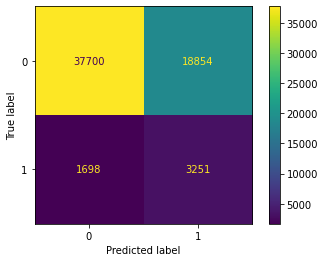

In [ ]:
plot_confusion_matrix(log_reg_over_smote, X_test, y_test)

In [ ]:
roc_auc_score(y_test, predictions_smote)

0.6617599490043342

In [ ]:
df_calculation = application_train.merge(previous_application, how='left', on='SK_ID_CURR')

In [ ]:
debt_test = pd.DataFrame(df_calculation.iloc[y_test.index.tolist(),:]['AMT_APPLICATION'])

It would be hard to know which method would be applied without the business context. In this problem, we would use the money lost to figure out the better model with the help of other metrics

In [ ]:
debt_test['true_prediction'] = y_test
debt_test['predicted_value'] = predictions_smote
debt_test['difference'] = debt_test['true_prediction'] - debt_test['predicted_value']
print('The estimated value of money lost due because of not identifying the default one is: ', debt_test[debt_test['difference']==1]['AMT_APPLICATION'].sum())
print('The estimated value of money lost due because of losing the potential customer is: ', debt_test[debt_test['difference']==-1]['AMT_APPLICATION'].sum())

The estimated value of money lost due because of not identifying the default one is:  305036432.145
The estimated value of money lost due because of losing the potential customer is:  3260513399.9400005


# ROC - AUC CURVE

https://www.kaggle.com/code/nicholasgah/obtain-optimal-probability-threshold-using-roc

In [ ]:
def plot_roc_auc_score(y_test, predicted_proba):
  false_pos_rate, true_pos_rate, proba = roc_curve(y_test, predicted_proba[:, -1])
  optimal_proba_cutoff = sorted(list(zip(np.abs(true_pos_rate - false_pos_rate), proba)), key=lambda i: i[0], reverse=True)[0][1]
  print('The optimal probability cut-off is: ', optimal_proba_cutoff)
  plt.figure()
  plt.plot([0,1], [0,1], linestyle="--") # plot random curve
  plt.plot(false_pos_rate, true_pos_rate, marker=".", label=f"AUC = {roc_auc_score(y_test, predicted_proba[:, -1])}")
  plt.title("ROC Curve")
  plt.ylabel("True Positive Rate")
  plt.xlabel("False Positive Rate")
  plt.legend(loc="lower right")
  roc_predictions = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_proba[:, -1]]
  return roc_predictions

## Find optimal Threshold

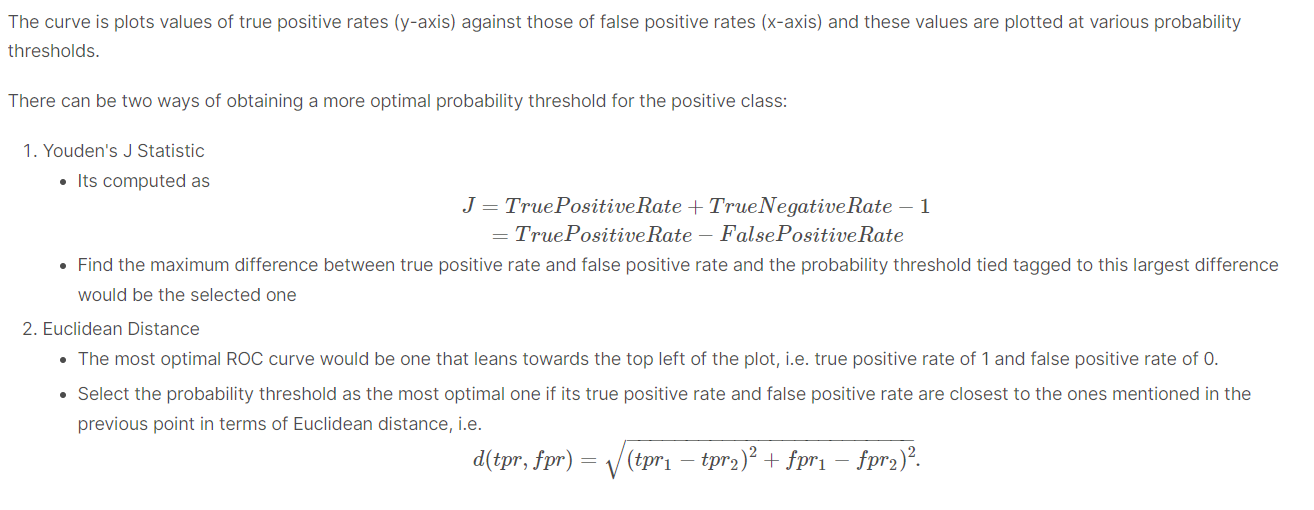

# APPYING ADVANCED MODEL

## FUNCTION NEEDED

In [ ]:
def run_model(model, X_train, X_test, y_train, y_test, test):
  model.fit(X_train, y_train)
  # best_iteration = model.best_iteration_
  predicted_proba = model.predict_proba(X_test)
  predicted_only = model.predict(X_test)
  roc_prediction = plot_roc_auc_score(y_test, predicted_proba)
  submitted_prediction = model.predict_proba(test)[:,1]
  print('The confusion matrix: ')
  plot_confusion_matrix(model, X_test, y_test)
  df_calculation = application_train.merge(previous_application, how='left', on='SK_ID_CURR')
  debt_test = pd.DataFrame(df_calculation.iloc[y_test.index.tolist(),:]['AMT_APPLICATION'])
  debt_test['true_prediction'] = y_test
  debt_test['predicted_value'] = predicted_only
  debt_test['difference'] = debt_test['true_prediction'] - debt_test['predicted_value']
  print('The estimated value of money lost due because of not identifying the default one is: ', debt_test[debt_test['difference']==1]['AMT_APPLICATION'].sum())
  print('The estimated value of money lost due because of losing the potential customer is: ', debt_test[debt_test['difference']==-1]['AMT_APPLICATION'].sum())

  return submitted_prediction

In [ ]:
def find_best_model_gridsearch(param_grid, model, X_train, y_train):
  model_search = GridSearchCV(estimator=model,
                              param_grid=param_grid,
                              cv=3,
                              n_jobs=-1,
                              verbose=1,
                              scoring='roc_auc')
  print('Searching params for the model...')
  model_search.fit(X_train, y_train)

  best_params = model_search.best_params_
  print('The best parameters for the model: ', best_params)

  return best_params

In [ ]:
def find_best_model(param_grid, model, X_train, y_train):
  model_search = RandomizedSearchCV(estimator=model,
                                    param_distributions=param_grid,
                                    n_iter=10,
                                    cv=3,
                                    n_jobs=-1,
                                    verbose=1,
                                    random_state=42,
                                    scoring='roc_auc')
  print('Searching params for the model...')
  model_search.fit(X_train, y_train)

  best_params = model_search.best_params_
  print('The best parameters for the model: ', best_params)

  return best_params

## RANDOM FOREST

In [ ]:
random_forest = RandomForestClassifier(n_estimators=100, random_state=42, verbose=1, n_jobs=-1)

In [ ]:
# random_forest.fit(X_train_over_sample_smote, y_train_over_sample_smote)

In [ ]:
# predicted_proba = random_forest.predict_proba(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.5min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.5s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    5.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    2.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


The optimal probability cut-off is:  0.18


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    2.2s finished
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


The confusion matrix: 


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    2.3s finished


The estimated value of money lost due because of not identifying the default one is:  826553789.775
The estimated value of money lost due because of losing the potential customer is:  28581837.75


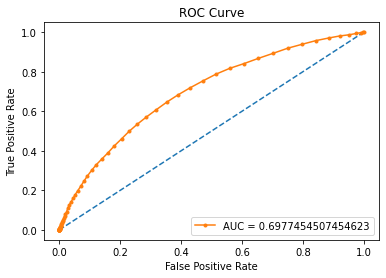

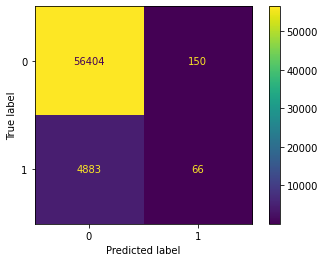

In [ ]:
submitted_prediction_rfc = run_model(random_forest, X_train_over_sample_smote, X_test, y_train_over_sample_smote, y_test, test)

## LIGHT GRADIENT BOOSTING

In [ ]:
lgbm_classifier = lgb.LGBMClassifier(n_estimators=5000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.02, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.9, n_jobs = -1,)

In [ ]:
# def run_model(model, X_train, X_test, y_train, y_test, test):
#   model.fit(X_train, y_train)
#   # best_iteration = model.best_iteration_
#   predicted_proba = model.predict_proba(X_test)
#   predicted_only = model.predict(X_test)
#   roc_prediction = plot_roc_auc_score(y_test, predicted_proba)
#   submitted_prediction = model.predict_proba(test)[:,1]
#   print('The confusion matrix: ')
#   plot_confusion_matrix(model, X_test, y_test)
#   return submitted_prediction

The optimal probability cut-off is:  0.08120972324343366
The confusion matrix: 


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


The estimated value of money lost due because of not identifying the default one is:  815496042.375
The estimated value of money lost due because of losing the potential customer is:  24783574.05


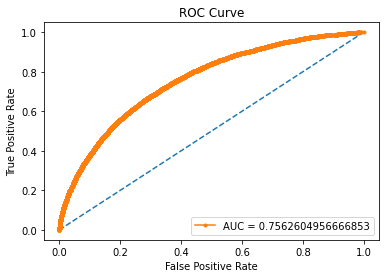

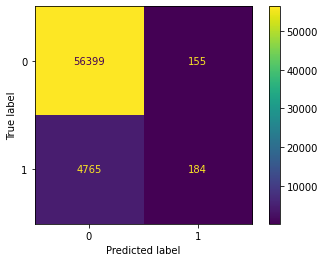

In [ ]:
submitted_prediction_lgbm = run_model(lgbm_classifier, X_train_over_sample_smote, X_test, y_train_over_sample_smote, y_test, test)

# SAVE PREDICTION

In [ ]:
def save_prediction(application_test, predicted_proba):
  final = pd.DataFrame()
  final['SK_ID_CURR'] = application_test['SK_ID_CURR']
  final['TARGET'] = predicted_proba
  final.to_csv('submission.csv', index=False)
  return final

In [ ]:
df = save_prediction(application_test, submitted_prediction_lgbm)